In [ ]:
# ADAPTED FROM FILE LJ_newmain_Conor

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import itertools
import math
from functools import total_ordering
from numpy.random import default_rng

In [3]:
class LJParticles:
    def __init__(self, nx = 2, ny = 2, Lx = 4, Ly = 4, initialKE = 0, dt = 0.01, tmax = 5, 
                 dispEvery = 1, rng_seed = 42, cool = False):
        """
        Initializes a Lennard-Jones molecular dynamics simulation.
        """
        
        self.rng = default_rng(seed = rng_seed)
        
        # Total number of particles
        self.N = nx * ny
        
        # Arrays for positions
        self.x = np.zeros(self.N)
        self.y = np.zeros(self.N)
        
        # Arrays for velocities
        self.vx = np.zeros(self.N)
        self.vy = np.zeros(self.N)
        
        # Arrays for accelerations
        self.ax = np.zeros(self.N)
        self.ay = np.zeros(self.N)
        
        # Number of particles per row and column
        self.nx = nx
        self.ny = ny
        
        # Box width and height
        self.Lx = Lx
        self.Ly = Ly
        
        # Number density of particles
        self.rho = self.N / (self.Lx * self.Ly)
        
        # Initial kinetic energy per particle
        self.initialKE = initialKE        
        
        # time variables
        
        self.dt = dt # Time step
        self.t = 0 # Time since simulation began
        self.tmax = tmax # Time when simulation ends
        self.steps = 0 # number of simulation steps
        
        # number of advance calls per update to display
        self.dispEvery = dispEvery
        
        # Remember energies for graphs
        self.histPE = []
        self.histKE = []
        
        # Tells us if system cools over time
        self.cool = cool
        
        #set velocities and positions
        self.setVelocities()
        self.setRectangularLattice()
        
    def setVelocities(self):
        """
        Sets initial velocities according to desired kinetic energy.
        """
        vxSum = 0.0
        vySum = 0.0
        
        N = self.N
        
        # Generate random initial velocities
        for i in range(N):
            self.vx[i] += self.rng.random() - 0.5
            self.vy[i] += self.rng.random() - 0.5
            
            vxSum += self.vx[i]
            vySum += self.vy[i]
            
        # Zero the center of mass momentum
        vxcm = vxSum / N   # Center of mass velocity (numerically equal to momentum)
        vycm = vySum / N
        
        for i in range(N):
            self.vx[i] -= vxcm
            self.vy[i] -= vycm
        
        # Rescale velocities to get desired initial kinetic energy
        v2sum = 0
        
        for i in range(N):
            v2sum += self.vx[i]**2 + self.vy[i]**2
        
        kineticEnergyPerParticle = 0.5 * v2sum / N
        
        rescale = math.sqrt(self.initialKE / kineticEnergyPerParticle)
        
        for i in range(N):
            self.vx[i] *= rescale
            self.vy[i] *= rescale
        
    # This function should be changed so that particles end up at the points where they first make
    # contact with the wall *is this needed?
    def applyBC(self, i):
        """
        Updates disk i according to hard-wall boundary conditions.
        """
        if self.x[i] > self.Lx:
#             self.y[i] -= (self.Lx-self.x[i]) * (self.vy[i] / self.vx[i])
            self.x[i] = self.Lx
            self.vx[i] = -abs(self.vx[i])
        elif self.x[i] < 0:
#             self.y[i] += (self.x[i]) * (self.vy[i] / self.vx[i])
            self.x[i] = 0
            self.vx[i] = abs(self.vx[i])
        
        if self.y[i] > self.Ly:
#             self.x[i] -= (self.Ly-self.y[i]) * (self.vx[i] / self.vy[i])
            self.y[i] = self.Ly
            self.vy[i] = -abs(self.vy[i])
        elif self.y[i] < 0:
#             self.x[i] += (self.y[i]) * (self.vx[i] / self.vy[i])
            self.y[i] = 0
            self.vy[i] = abs(self.vy[i])
    
    
    def setRectangularLattice(self):
        """
        Arranges the particles on an nx by ny rectangular lattice.
        Particles are offset from the edges by 1 unit.
        """
        
        # Horizontal and vertical spacings
        dx = (self.Lx - 2) / (self.nx - 1)
        dy = (self.Ly - 2) / (self.ny - 1)
        
        # Set initial positions
        for ix in range(self.nx):
            for iy in range(self.ny):
                i = ix + iy * self.ny
                self.x[i] = 1 + dx * ix
                self.y[i] = 1 + dy * iy
                
    
    def computeAcceleration(self):
        """
        Computes the acceleration of each particle due to Lennard-Jones forces.
        """
        N = self.N
        
        for i in range(N):
            self.ax[i] = 0
            self.ay[i] = 0
        
        totalPEthistime = 0
        
        # For any two particles...
        for i in range(N):
            for j in range(i + 1, N): #Conor's note: I think this could just be range(i)
                
                # Find the separations
                dx = self.x[i] - self.x[j]
                dy = self.y[i] - self.y[j]
                
                r2 = dx**2 + dy**2
                
                oneOverR2 = 1.0 / r2
                oneOverR6 = oneOverR2**3
                
                # Calculate the Lennard-Jones force
                fOverR = 48 * oneOverR6 * (oneOverR6 - 0.5) * oneOverR2
                
                fx = fOverR * dx
                fy = fOverR * dy
                
                # Update accelerations
                self.ax[i] += fx
                self.ay[i] += fy
                self.ax[j] -= fx
                self.ay[j] -= fy
                
                # Add to PE for this run
                totalPEthistime += 4 * (oneOverR6**2 - oneOverR6)
        
        self.histPE.append(totalPEthistime)
                
    
    
    def advance(self):
        """
        Advances the simulation by one time step. Velocity is updated using the average of old and
        new acceleration
        """
        N = self.N
        halfdt = 0.5 * self.dt
        halfdt2 = 0.5 * self.dt**2
        
        # For each particle...
        for i in range(N):
            
            # Update position
            self.x[i] += self.vx[i] * self.dt + self.ax[i] * halfdt2
            self.y[i] += self.vy[i] * self.dt + self.ay[i] * halfdt2
            
            self.applyBC(i)
            
            # Update velocity with old acceleration
            self.vx[i] += self.ax[i] * halfdt
            self.vy[i] += self.ay[i] * halfdt
            
        self.computeAcceleration()
        
#         print("X acceleration:", self.ax)
#         print("Y acceleration:", self.ay)
#         print()
        
        # Update with new acceleration
        for i in range(N):
            self.vx[i] += self.ax[i] * halfdt
            self.vy[i] += self.ay[i] * halfdt
        
        # Cool the system if desired
        if self.cool and self.steps % 200 == 0 and self.steps <= 8000:
            self.cools()
        
        # Compute the system's new kinetic energy
        totalKE = 0
        
        for i in range(N):
            v2 = self.vx[i]**2 + self.vy[i]**2
            totalKE += v2
        
        totalKE *= 0.5
        
        self.histKE.append(totalKE)
        
        # We've advanced 1 time step
        self.steps += 1
        self.t += self.dt

      
    
    def cools(self):
        """
        Cools the system by reducing its kinetic energy.
        """
        N = self.N
        
        for i in range(N):
            self.vx[i] *= 0.9
            self.vy[i] *= 0.9

            
    def saveAnimation(self, filename="LJ"):
        """
        Creates an animation of our Lennard-Jones system.
        """
        
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.Lx)
        ax.set_ylim(0, self.Ly)
        points, = ax.plot(self.x, self.y, 'o', markersize=8)
        title = ax.set_title("default starting title")
        

        def frame(_=0):
            """
            Advances the animation.
            """
            
            # Firstly, and most importantly, display the progress bar.
            x = int(np.floor(32 * self.t / self.tmax) + 1)
            print ("[" + "████████████████████████████████"[:x-1] + "▄" * (x < 32) + "▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁"[x:] + "]  ", end="\r")
            
            # Advance simulation by dispEvery time steps
            for i in range(self.dispEvery):
                self.advance()
            
            # Enter new particle positions
            points.set_data(self.x, self.y)
            
            title = ax.set_title("t = {:0.2f}".format(self.t))
            
            return points, title
        
        ani = FuncAnimation(fig, frame, frames = int((self.tmax//self.dt)//self.dispEvery),
                            interval = 20, blit = True)
        
        ani.save(filename+".gif")
        plt.close()
        
        return self.histPE, self.histKE

MovieWriter ffmpeg unavailable; using Pillow instead.


-28.52243526385627 -28.52010748013536


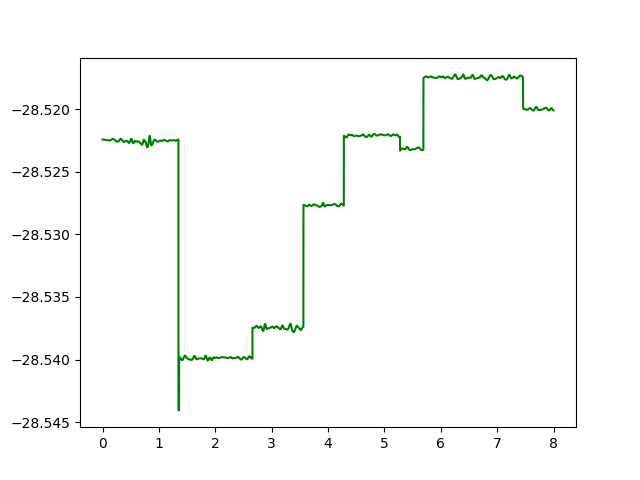

In [4]:
# TEST CELL: 25 PARTICLES, NO COOLING

dt = 0.001
tmax = 8

LJ = LJParticles(initialKE = .3, Lx = 7, Ly = 7, nx=5, ny=5, dt=dt, tmax=tmax, dispEvery=10)
PEs, KEs = LJ.saveAnimation("oldWallCollisionCode")
TEs = [PEs[i] + KEs[i] for i in range(len(PEs))]
print(TEs[0], TEs[-1])

tvar = np.arange(0,tmax,dt)
fig, ax = plt.subplots()
# ax.plot(tvar, PEs, "b", label="PE")
# ax.plot(tvar, KEs, "r", label="KE")
ax.plot(tvar, TEs, "g", label="TE");

In [ ]:
# TEST CELL: 9 PARTICLES, YES COOLING

dt = 0.001
tmax = 8

LJ = LJParticles(initialKE = .3, nx=3, ny=3, dt=dt, tmax=tmax, dispEvery=10, cool = True)
PEs, KEs = LJ.saveAnimation()
TEs = [PEs[i] + KEs[i] for i in range(len(PEs))]
print(TEs[0], TEs[-1])

tvar = np.arange(0,tmax,dt)
fig, ax = plt.subplots()
ax.plot(tvar, PEs, "b", label="PE")
ax.plot(tvar, KEs, "r", label="KE")
ax.plot(tvar, TEs, "g", label="TE");

In [ ]:
plt.close("all")

In [ ]:
# TEST CELL: 49 PARTICLES, YES COOLING

dt = 0.001
tmax = 12

LJ = LJParticles(initialKE = .3, Lx = 7, Ly = 7, nx=7, ny=7, dt=dt, tmax=tmax, dispEvery=10, cool = True)
PEs, KEs = LJ.saveAnimation("coolExpt1")
TEs = [PEs[i] + KEs[i] for i in range(len(PEs))]
print(TEs[0], TEs[-1])

tvar = np.arange(0,tmax,dt)
fig, ax = plt.subplots()
ax.plot(tvar, PEs, "b", label="PE")
ax.plot(tvar, KEs, "r", label="KE")
ax.plot(tvar, TEs, "g", label="TE");